In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import xarray as xr

from pprint import pprint
import hhclusters

import utils

from importlib import reload
reload(utils)

<module 'utils' from '/home/jungyoung/Project/hh_neuralnet/dynamics_clustering/utils.py'>

In [186]:
!ls ../three_pop_mpi/simulation_data

collected_data.pkl  descript.txt  orders_dyna.pkl  purified_data.pkl
data		    orders.pkl	  postdata.nc


In [ ]:
features.key

In [143]:
# set target files
fname_features = "../three_pop_mpi/simulation_data/postdata.nc"
fname_clusters = "./data/cluster_id_sub.nc"

# fname_features = "../mono_pop_mpi/simulation_data/postdata_fast.nc"
# fname_clusters = "./data/cluster_id_mfast.nc"

# Read file
features = xr.load_dataarray(fname_features)
clusters = xr.load_dataset(fname_clusters)

nums, num_total = [], 1
for k in ("alpha", "beta", "rank", "w"):
    nums.append(len(clusters.coords[k]))
    num_total *= nums[-1]
print(nums)

target_keys = ("chi", "cv", "frs_m", "ac2p_large", "tlag_large", "ac2p_1st", "tlag_1st", "cc1p", "tlag_cc", "leading_ratio", "leading_ratio(abs)")
include_var = (True, False, True, True, True, True, True, True, True, False, False)
inverse_mean = (False, False, False, False, True, False, True, False, False, False, False)
num_pops = (2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1)

[15, 15, 3, 16]


In [179]:
# collect data set
dataset = np.zeros((num_total, len(include_var), 2, 2)) # mean/var, pop_types

nstack = 0
for na in range(nums[0]):
    for nb in range(nums[1]):
        for nr in range(nums[2]):
            for nw in range(nums[3]):
                val = features.sel(key=list(target_keys)).isel(alpha=na, beta=nb, rank=nr, w=nw)
                dataset[nstack,...,0] = val.sel(pop="F", type=["mean", "var"])
                dataset[nstack,...,1] = val.sel(pop="S", type=["mean", "var"])
                nstack += 1

for nk in range(len(target_keys)):
    if num_pops[nk] == 1:
        dataset[:,nk,:,1] = np.nan
    if inverse_mean[nk]:
        dataset[:,nk,0,:] = 1/dataset[:,nk,0,:]
    if not include_var[nk]:
        dataset[:,nk,1,:] = np.nan
                
# get cid and silhouette value
cid_flat = clusters.cluster_id.data.flatten()
sval_flat = clusters.sval.data.flatten()

In [182]:
# align dataset
align_dataset = np.zeros_like(dataset)

nstack = 0
for cid in clusters.id_set:
    is_in = cid_flat == cid
    
    nin = np.sum(is_in)
    data_sub = dataset[is_in,...]
    sval_sub = sval_flat[is_in]
    
    # sort value
    id_sort = np.argsort(sval_sub)[::-1]
    
    align_dataset[nstack:nstack+nin,...] = data_sub[id_sort,...]
    nstack += nin

In [183]:
# flat dataset
flat_dataset = []
flat_labels = []

key_pops = ("F", "S")
key2lb_inv = {"tlag_1st": "f_1",
              "tlag_large": "f_2"}

for nk in range(len(target_keys)):
    key = target_keys[nk]
    if inverse_mean[nk]:
        lb = key2lb_inv[key]
    elif key == "cv":
        lb = "cv"
    else:
        lb = utils.key2lb[key]
    
    for npop in range(num_pops[nk]):
        if num_pops[nk] > 1:
            lb = target_keys[nk] + key_pops[npop]
        
        for nv in range(2):
            if not include_var[nk] and nv == 1: continue
            if nv == 0:
                lb = "\leftangle %s \rightangle"%(lb)
            else:
                lb = "\sigma [%s]"%(lb)
                
            x = align_dataset[:,nk,nv,npop]
            assert not np.any(np.isnan(x))
            
            flat_dataset.append(x)
            flat_labels.append(lb)

flat_dataset = np.swapaxes(flat_dataset, 1, 0)

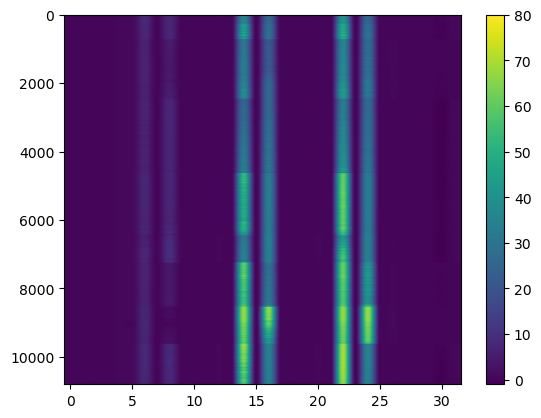

In [185]:
plt.figure()
plt.imshow(flat_dataset, aspect="auto", vmax=80)
plt.colorbar()
plt.show()